# score

> Quantify staining of IHC images

In [ ]:
#| default_exp score

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
from matplotlib import pyplot
import skimage as ski

## Pixel-wise H score

In [ ]:
#| export
def compute_pxlhscore(
        hed_img, 
        h_threshold=0.05, d_thresholds=[0.12, 0.24, 0.6],
        verbose=False):
    """

    Computes the pixel H-score for a given HED (Hematoxylin and Eosin-DAB) stained image.
    
    The H-score is calculated based on the intensity of the DAB stain, which is 
    indicative of the presence and quantity of a specific biomarker in IHC images. 
    The function allows for automatic thresholding based on the distribution of staining intensities.
    Inspired by the implementation in Ram et al. 2021.
    
    Parameters:

    - hed_img (numpy.ndarray): The HED-stained image as a NumPy array of shape 
        (height, width, channels).

    - h_threshold (str or float): Threshold for Hematoxylin intensity. 
        If 'default', the threshold is set to 0.05.
        If 'static', the threshold is set to the mean intensity.
        If 'auto', the threshold is set based on Otsu's thresholding.

    - d_thresholds (str or list of floats): Thresholds for DAB intensity, 
        defining negative, low, medium, and high intensity ranges.
        If 'default', thresholds are set to [0.12, 0.24, 0.6].
        If 'static', thresholds are set to the 90th, 94.95th, and 99.9th percentiles.
        If 'auto', thresholds are set based on Otsu's thresholding for 3 classes.

    - verbose (bool): If True, displays histograms of the distributions of 
        Hematoxylin and DAB stain values, and images showing pixels classified 
        as high, medium, low, and negative DAB stained.
    
    Returns:

    - pxlHscore (float): The pixel H-score, a weighted sum of pixels classified 
        as having high, medium, or low DAB intensity, 
        normalized by the total number of pixels considered.
        
    """
    
    # Flatten the H and D channels for thresholding and histogram plotting
    h_array = hed_img[:, :, 0].flatten()
    d_array = hed_img[:, :, 2].flatten()
    
    # Hematoxylin thresholds
    if h_threshold == "default":
        h_threshold = 0.05
    elif h_threshold == "static":
        h_threshold = np.mean(h_array)
    elif h_threshold == "auto":
        h_threshold = ski.filters.threshold_otsu(
            image=h_array, nbins=256, hist=None)
    # DAB thresholds
    if d_thresholds == "default":
        d_thresholds = [0.12, 0.24, 0.6]
    elif d_thresholds == "static":
        d_thresholds = np.quantile(d_array, [0.9, 0.9495, 0.999])
    elif d_thresholds == "auto":
        d_thresholds = ski.filters.threshold_multiotsu(
            image=d_array, classes=4, 
            nbins=256, hist=None)
        
    # Plotting histograms if verbose mode is on
    if verbose:
        pyplot.figure()
        pyplot.hist(d_array, bins=50, density=True, cumulative=False, color="blue", edgecolor="black")
        pyplot.yscale("log")
        pyplot.title("Distribution of DAB stain Values")
        pyplot.xlabel("Value")
        pyplot.ylabel("Frequency (log scale)")
        pyplot.show()
        
        pyplot.figure()
        pyplot.hist(h_array, bins=50, density=True, cumulative=False, color="blue", edgecolor="black")
        pyplot.yscale("log")
        pyplot.title("Distribution of Hematoxylin Values")
        pyplot.xlabel("Value")
        pyplot.ylabel("Frequency (log scale)")
        pyplot.show()
    
    # Classifying pixels based on DAB intensity thresholds
    h_pixels = hed_img[:, :, 0] > h_threshold
    dn_pixels = hed_img[:, :, 2] < d_thresholds[0]
    dl_pixels = (hed_img[:, :, 2] >= d_thresholds[0]) & (hed_img[:, :, 2] < d_thresholds[1])
    dm_pixels = (hed_img[:, :, 2] >= d_thresholds[1]) & (hed_img[:, :, 2] < d_thresholds[2])
    dh_pixels = hed_img[:, :, 2] >= d_thresholds[2]
    n_pixels = h_pixels & dn_pixels
    
    # Displaying classified pixels if verbose mode is on
    if verbose:
        print(f"Mean intensity for H pixels: {h_pixels.mean()}")
        print(f"Mean intensity for DN pixels: {dn_pixels.mean()}")
        print(f"Mean intensity for DL pixels: {dl_pixels.mean()}")
        print(f"Mean intensity for DM pixels: {dm_pixels.mean()}")
        print(f"Mean intensity for DH pixels: {dh_pixels.mean()}")
        print(f"Mean intensity for N pixels: {n_pixels.mean()}")
        
        fig, axs = pyplot.subplots(2, 2, figsize=(6, 6))
        axs[0, 0].imshow(dh_pixels)
        axs[0, 0].set_title("High DAB")
        axs[0, 1].imshow(dm_pixels)
        axs[0, 1].set_title("Med DAB")
        axs[1, 0].imshow(dl_pixels)
        axs[1, 0].set_title("Low DAB")
        axs[1, 1].imshow(n_pixels)
        axs[1, 1].set_title("Negative")
        for ax_row in axs:
            for ax in ax_row:
                ax.axis("off")
        pyplot.show()
    
    # Calculating the pixel H-score
    dh_pixels_sum = dh_pixels.sum()
    dm_pixels_sum = dm_pixels.sum()
    dl_pixels_sum = dl_pixels.sum()
    pxlHscore = 100 * (3 * dh_pixels_sum + 2 * dm_pixels_sum + dl_pixels_sum) / (dh_pixels_sum + dm_pixels_sum + dl_pixels_sum + n_pixels.sum())
    
    if verbose:
        print(f"Haematoxylin threshold: {h_threshold}")
        print(f"DAB thresholds: {d_thresholds}")
        print(f"Pixel H-score: {pxlHscore}")
    
    return pxlHscore

The pixelwise H-score is computed as follows:

$$\
pxlH = 100 \times \frac{3 \times N_{DH} + 2 \times N_{DM} + N_{DL}}{N_{DH} + N_{DM} + N_{DL} + N_{N}}
$$

where:

- $\N_{DH}$ is the number of pixels with high DAB intensity,

- $\N_{DM}$ is the number of pixels with medium DAB intensity,

- $\N_{DL}$ is the number of pixels with low DAB intensity,

- $\N_{N}$ is the number of pixels with negative DAB intensity.

Example

<matplotlib.image.AxesImage>

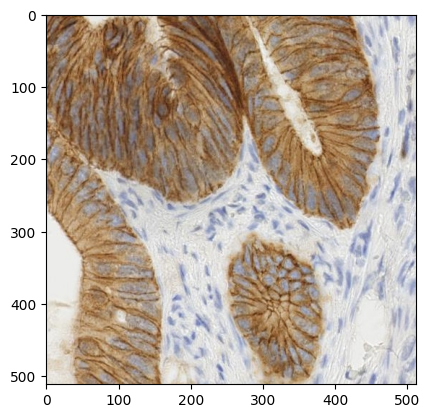

In [ ]:
ihc_rgb = ski.data.immunohistochemistry()
pyplot.imshow(ihc_rgb)

In [ ]:
ihc_hed = ski.color.rgb2hed(ihc_rgb)

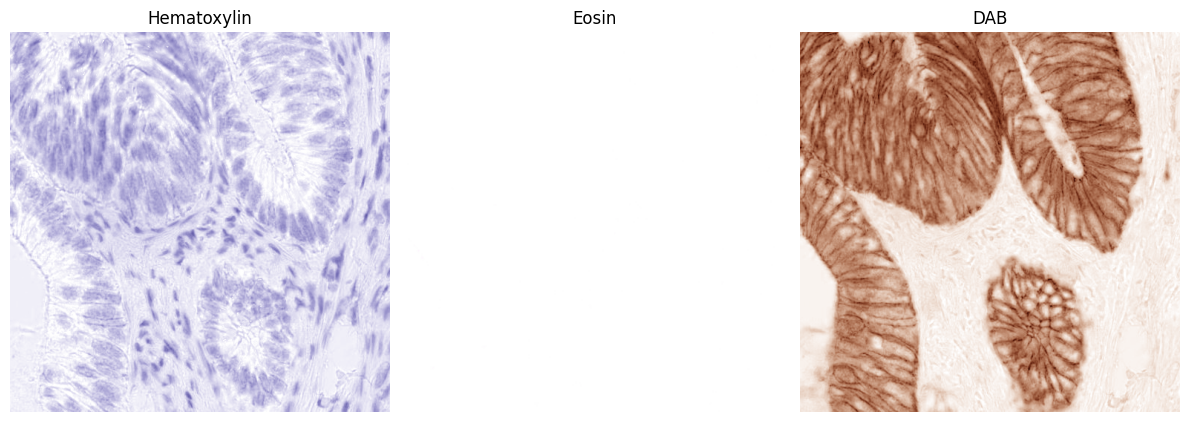

In [ ]:
stain_names = ["Hematoxylin", "Eosin", "DAB"]
fig, axes = pyplot.subplots(1, 3, figsize=(12, 6)) 

null = np.zeros_like(ihc_hed[:, :, 0])

for i, name in enumerate(stain_names):
    # Create an RGB image for the current stain
    channels = [null, null, null]
    channels[i] = ihc_hed[:, :, i]
    rgb_img = ski.color.hed2rgb(np.stack(channels, axis=-1))
    
    # Display
    axes[i].imshow(rgb_img)
    axes[i].set_title(name)
    axes[i].axis("off")

pyplot.tight_layout()
pyplot.show()

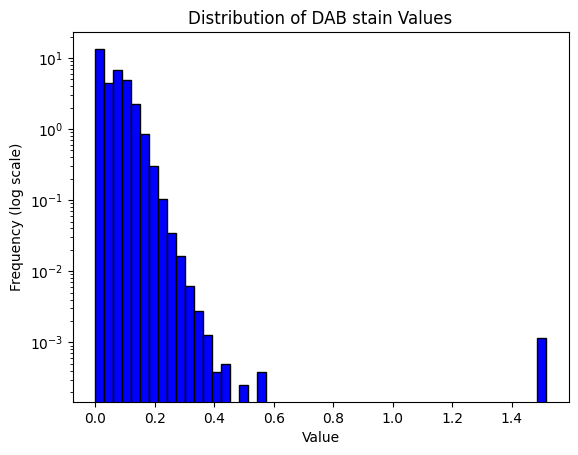

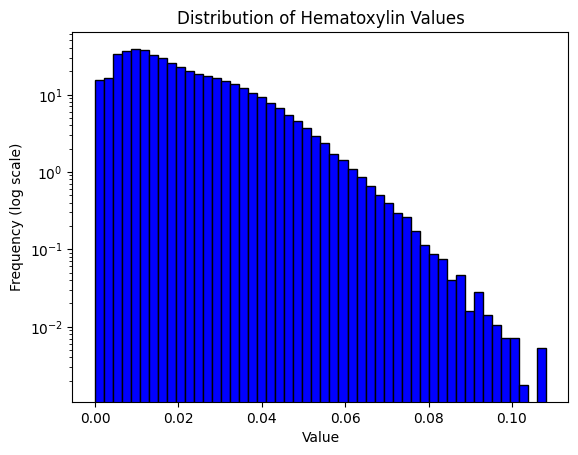

Mean intensity for H pixels: 0.035449981689453125
Mean intensity for DN pixels: 0.88824462890625
Mean intensity for DL pixels: 0.10962677001953125
Mean intensity for DM pixels: 0.002094268798828125
Mean intensity for DH pixels: 3.4332275390625e-05
Mean intensity for N pixels: 0.031993865966796875


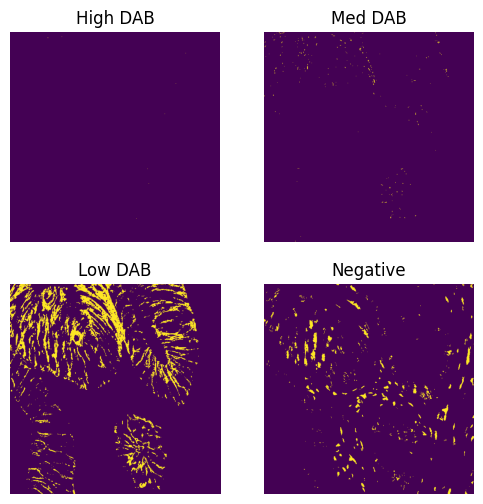

Haematoxylin threshold: 0.05
DAB thresholds: [0.12, 0.24, 0.6]
Pixel H-score: 79.24793673539793
79.24793673539793


In [ ]:
result = compute_pxlhscore(ihc_hed, verbose=True)
print(result)

In [ ]:
assert result == compute_pxlhscore(ihc_hed, d_thresholds=[0.12, 0.24, 0.6]) == compute_pxlhscore(ihc_hed, d_thresholds="default")

In [ ]:
assert result == compute_pxlhscore(ihc_hed, h_threshold=0.05) == compute_pxlhscore(ihc_hed, h_threshold="default")

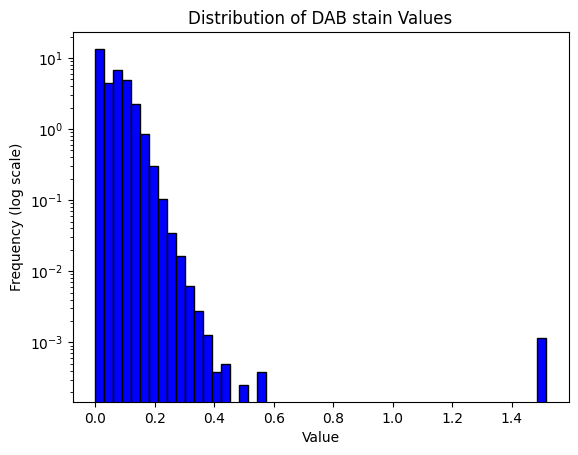

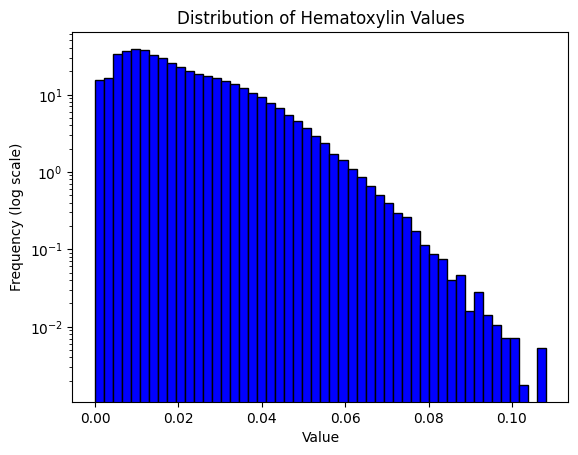

Mean intensity for H pixels: 0.4108695983886719
Mean intensity for DN pixels: 0.8999786376953125
Mean intensity for DL pixels: 0.04950714111328125
Mean intensity for DM pixels: 0.049510955810546875
Mean intensity for DH pixels: 0.001003265380859375
Mean intensity for N pixels: 0.3635520935058594


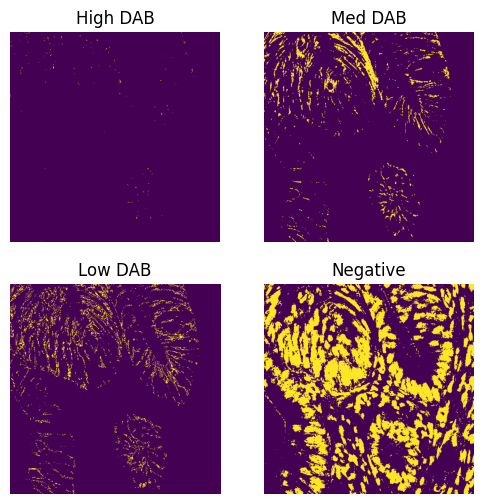

Haematoxylin threshold: 0.02006582564164016
DAB thresholds: [0.12352821 0.14450278 0.26666182]
Pixel H-score: 32.689285155896414
32.689285155896414


In [ ]:
result = compute_pxlhscore(ihc_hed, h_threshold="static", d_thresholds="static", verbose=True)
print(result)

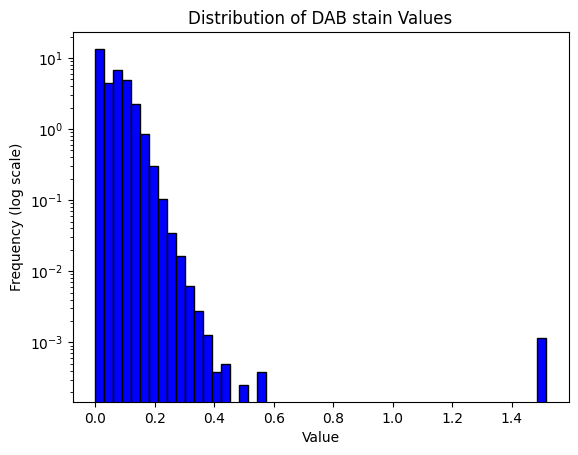

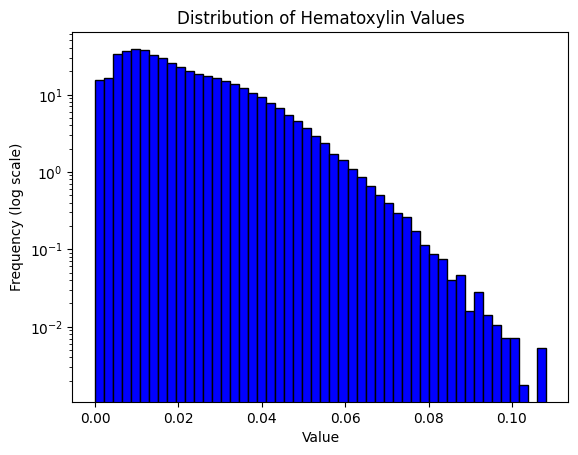

Mean intensity for H pixels: 0.3234710693359375
Mean intensity for DN pixels: 0.43198394775390625
Mean intensity for DL pixels: 0.279510498046875
Mean intensity for DM pixels: 0.22780609130859375
Mean intensity for DH pixels: 0.060699462890625
Mean intensity for N pixels: 0.10207366943359375


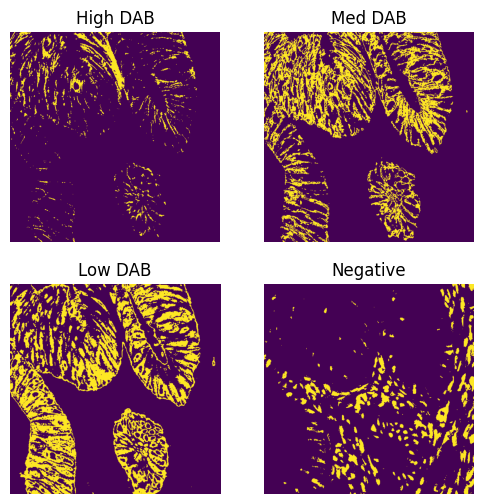

Haematoxylin threshold: 0.024294931878818742
DAB thresholds: [0.03847427 0.08582721 0.13909927]
Pixel H-score: 136.88033701468746
136.88033701468746


In [ ]:
result = compute_pxlhscore(ihc_hed, h_threshold="auto", d_thresholds="auto", verbose=True)
print(result)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()